In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import joblib

In [113]:
# Установка начальных параметров
random.seed(42)  # Зафиксируем seed для воспроизводимости результатов
np.random.seed(42)
num_samples = 3000  # Количество записей
start_date = datetime(2023, 1, 1)  # Начальная дата
work_hours_start = 9  # Начало рабочего дня
work_hours_end = 17  # Конец рабочего дня
time_to_read = 4  # Часы до прочтения
stress_keywords = ['stress', 'deadline', 'overwork']  # Ключевые слова для стресса
salary_change_keywords = ['salary', 'pay raise', 'compensation']  # Ключевые слова про изменение зарплаты
vacation_keywords = ['vacation', 'leave', 'time off']  # Ключевые слова про отпуск

# Генерация последовательных ID
starting_id = 1000  # Начальное значение ID
num_users = num_samples  # Количество пользователей

user_ids = [starting_id + i for i in range(num_users)]

In [223]:
# Генерация чисел в пропорциях 80% и 20%
percent_greater_than_05 = 0.3  # Процент чисел больше 0.5

# Создание массива чисел от 0 до 1
numbers = np.random.rand(num_samples)

# Определение количества чисел больше и меньше 0.5
num_greater_than_05 = int(num_samples * percent_greater_than_05)
num_less_than_05 = num_samples - num_greater_than_05

# Установка значений
numbers[num_greater_than_05:] *= 0.5  # Уменьшение чисел, начиная с определенного индекса

# Пример значений
print(numbers)

# Целевая переменная
resigned = numbers

[0.70002642 0.48428466 0.89996312 ... 0.27263584 0.09913117 0.40856899]


In [224]:
def add(low, high, reverse=False):
    if reverse:
        return [random.randint(low, high) if i <= 0.5 else low for i in resigned]
    else:
        return [low if i <= 0.5 else random.randint(low, high) for i in resigned]

In [225]:
sent_messages = np.int32(10 + np.random.poisson(50, num_samples) + add(7, 20)) # Количество отправленных сообщений
received_messages = np.int32(np.random.poisson(70, num_samples) + add(12, 30)) # Количество полученных сообщений
messages_outside_work_hours = np.int32(sent_messages * 0.1 + add(2, 7)) # Количество сообщений, отправленных вне рабочего дня
send_frequency = np.int32(sent_messages * 0.07 + np.random.poisson(10, num_samples)) # Частота отправки
receive_frequency = np.int32(received_messages * 0.07 + np.random.poisson(10, num_samples)) # Частота получения
sent_received_ratio = received_messages / (sent_messages + 1) # Соотношение количества полученных и отправленных сообщений

In [226]:
# Характеристики сообщений
recipients_in_sent = np.int32(add(1, 3, True) + np.random.poisson(5, num_samples)) # Количество адресатов в отправляемых сообщениях
hidden_copy = np.int32(recipients_in_sent * 0.05 + add(1, 3, True) + np.random.exponential(1, num_samples)) # Количество сообщений с адресатами в поле "скрытая копия"
carbon_copy = np.int32(recipients_in_sent * 0.15 + add(1, 4, True) + np.random.exponential(1, num_samples)) # Количество сообщений с адресатами в поле "копия"
text_length = np.int32(np.log(sent_messages + 1) * np.random.lognormal(3, 1, num_samples) + 100 * resigned) # Количество символов текста в исходящих сообщениях
bytes_ratio = add(0, 2)  +  np.random.uniform(0.5, 2.0, num_samples)  # Соотношение объема в байтах получаемых и отправляемых сообщений
question_marks = np.int32(np.random.uniform(2, 4, num_samples) + add(1, 2)) # Количество знаков вопроса

In [227]:
# Ответы и реакции
answered_messages = np.int32(np.random.normal(20, 5, num_samples) + add(3, 10)) # Количество сообщений, на которые пользователь получил ответ
unanswered_messages = np.int32(np.random.normal(10, 3, num_samples) + add(2, 7, True)) # Количество сообщений, на которые сотрудник не получил ответа
unreplied_messages = np.int32(np.random.normal(10, 3, num_samples) + add(2, 5, True)) # Количество сообщений, на которые сотрудник сам не ответил

In [228]:
# Типы взаимодействий и эмоции
mention_colleagues = np.int32((np.random.normal(2, 1, num_samples))) # Частота упоминания коллег в письмах
salary_change_info = np.round(np.random.choice([0, 1], num_samples) * resigned)  # Указание информации о изменении зарплаты
vacation_info =  np.round(np.random.choice([0, 1], num_samples) * (1 - resigned)) # Указание информации об отпуске
polite_message = np.round(np.random.choice([0, 1], num_samples) * resigned) # Является ли сообщение вежливым
mood_type =  np.round(np.random.choice([0, 1], num_samples) * resigned) # Настроение в сообщении
stress_keywords = np.int32(np.random.normal(1, 0.5, num_samples) + add(0, 2, True)) # Есть ли стрессовые слова в сообщении?

In [229]:
# Временные характеристики
response_time = np.int32(np.random.normal(3, 0.5, num_samples) + add(0, 3, True)) # Среднее время ответа на входящие сообщения
late_read_messages = np.int32(0.03 * received_messages + np.random.normal(1, 0.5, num_samples) + add(1, 3, True))
days_between_received_read = np.int32(np.random.normal(1, 0.5, num_samples) + add(0, 2, True))

In [230]:
# Генерация случайных данных
data = {
    # ID:
    'id': user_ids,

    # Общее количество сообщений
    'SentMessages': sent_messages,
    'ReceivedMessages': received_messages,
    'MessagesOutsideWorkHours': messages_outside_work_hours,
    'SentFrequency': send_frequency,
    'ReceivedFrequency': receive_frequency,
    'SentReceivedRatio': sent_received_ratio,

    # Характеристики сообщений
    'UniqueRecipients': recipients_in_sent,
    'HiddenCopy': hidden_copy,
    'CarbonCopy': carbon_copy,
    'TextLength': text_length,
    'BytesSentReceivedRatio': bytes_ratio,
    'QuestionMarks': question_marks,
    #
    # Временные характеристики
    'ResponseTime': response_time,
    'MessagesReadLater': late_read_messages,
    'DaysBetweenReceivedAndRead': days_between_received_read,

    # # Ответы и реакции
    'AnsweredMessages': answered_messages,
    'UnansweredMessages': unanswered_messages,
    'UnrepliedMessages': unreplied_messages,
    #
    # Типы взаимодействий и эмоции
    'MentionColleagues': mention_colleagues,
    'MoodType': mood_type,
    'StressKeywordsPresent': stress_keywords,
    'SalaryChangeMentioned':salary_change_info,
    'VacationMentioned': vacation_info,
    'PoliteMessage': polite_message,

    # Целевая переменная
    'Resigned': resigned  # Целевая переменная (0 - не уволился, 1 - уволился)
}

# Создание DataFrame из сгенерированных данных
df = pd.DataFrame(data)

# # Добавление временных меток сообщений
# date_list = [start_date + timedelta(days=random.randint(0, 365)) for _ in range(num_samples)]
# time_list = [random.randint(0, 23) for _ in range(num_samples)]
# df['MessageDateTime'] = [date + timedelta(hours=time) for date, time in zip(date_list, time_list)]


df['Resigned'] = [1 if i >= 0.5 else 0 for i in df['Resigned']]
df['Resigned'].value_counts()

Resigned
0    2544
1     456
Name: count, dtype: int64

In [231]:
# Типы взаимодействий и эмоции
# df['mention_colleagues'] = [1 if i >= 0.5 else 0 for i in df['mention_colleagues']]
df['MoodType'] = [1 if i >= 0.3 else 0 for i in df['MoodType']]
# df['StressKeywordsPresent'] = [1 if i >= 0.2 else 0 for i in df['StressKeywordsPresent']]
df['SalaryChangeMentioned'] = [1 if i >= 0.5 else 0 for i in df['SalaryChangeMentioned']]
df['VacationMentioned'] = [1 if i >= 0.3 else 0 for i in df['VacationMentioned']]
df['PoliteMessage'] = [1 if i >= 0.25 else 0 for i in df['PoliteMessage']]

<Axes: >

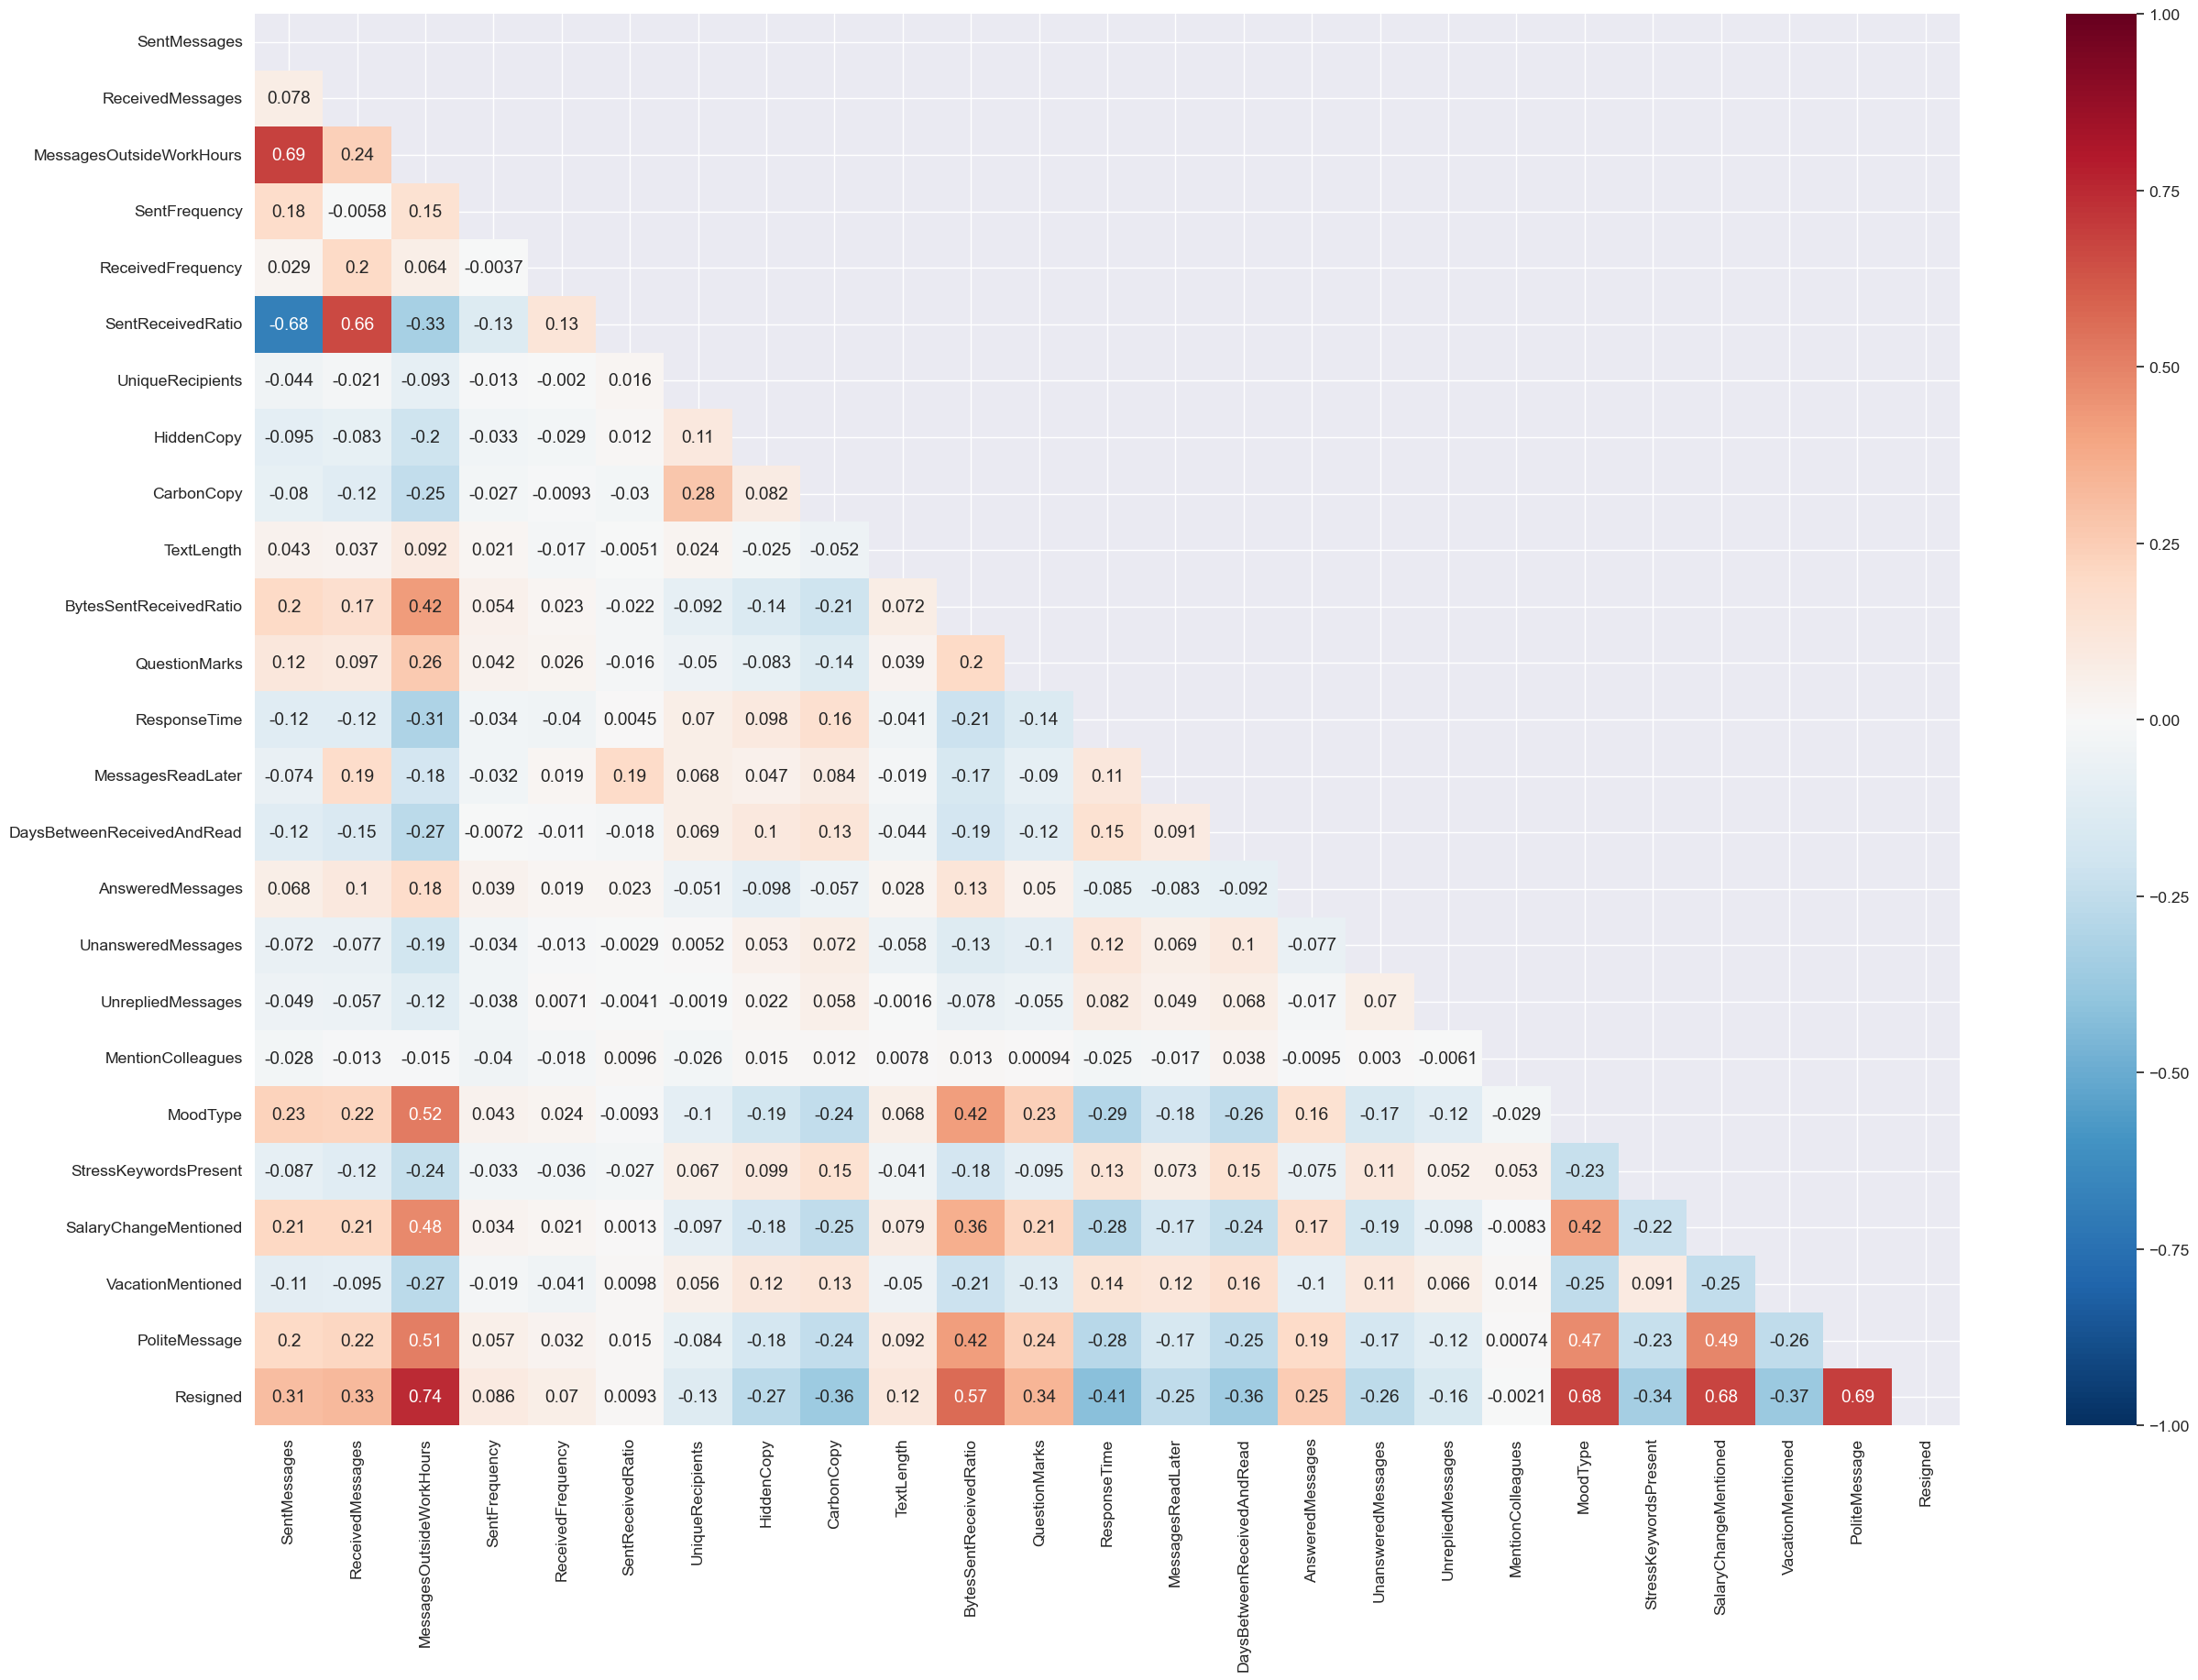

In [232]:
# Проверим корреляции
correlation_matrix = df.drop(columns=['id']).corr()

plt.figure(figsize=(30,20))
sns.set(font_scale=1.15)
sns.heatmap(correlation_matrix,
            cmap='RdBu_r', # задаёт цветовую схему
            annot=True, # рисует значения внутри ячеек
            vmin=-1, vmax=1,
            mask=np.triu(correlation_matrix))

In [233]:
# cols = ['mention_colleagues', 'MoodType', 'StressKeywordsPresent', 'SalaryChangeMentioned', 'VacationMentioned',  'polite_message',
#         'BytesSentReceivedRatio', 'question_marks']
# for col in cols:
#     print(df[col].value_counts())
#     # sns.displot(df, x=col, binwidth=3)
#     # plt.show()

In [234]:
# df.hist(figsize=(30, 20))

In [235]:
num_f = ['SentMessages', 'ReceivedMessages',
          'SentFrequency', 'ReceivedFrequency', 'SentReceivedRatio',
          'UniqueRecipients', 'TextLength',
          'BytesSentReceivedRatio']
joblib.dump(num_f, f'../data/num_f')

count_f = ['MessagesOutsideWorkHours', 'HiddenCopy', 'CarbonCopy', 'QuestionMarks', 'ResponseTime',
          'MessagesReadLater', 'DaysBetweenReceivedAndRead', 'AnsweredMessages',
          'UnansweredMessages', 'UnrepliedMessages']
joblib.dump(count_f, f'../data/count_f')

bin_f = ['MentionColleagues',
             'MoodType', 'StressKeywordsPresent', 'SalaryChangeMentioned',
             'VacationMentioned', 'PoliteMessage']
joblib.dump(bin_f, f'../data/bin_f')


['../data/bin_f']

In [165]:
def rand_group(x):
    return random.randint(1, 5)
rand_groups = [rand_group(1) for _ in range(len(df))]

In [236]:
groups_to_replace = {1: 'Development Department', 2: 'Quality Assurance', 3: 'IT Infrastructure', 4: 'Sales and Marketing', 5: 'Research and Development'}

df['Group'] = 0
df['Group'] = rand_groups
df['Group'] = df['Group'].replace(groups_to_replace)

In [237]:
# def rand_gender(x):
#     return random.randint(1, 2)
#
# groups_to_replace = {1: 'Male', 2: 'Female'}
#
# df['Gender'] = 0
# df['Gender'] = df['Gender'].apply(rand_gender).replace(groups_to_replace)

In [238]:
cols_to_drop = ['Group']
# Сохранение в файл
filename = f'../data/cols_to_drop'

joblib.dump(cols_to_drop, filename)

cols_full = list(df.columns)
# Сохранение в файл
filename = f'../data/cols_full'

joblib.dump(cols_full, filename)

['../data/cols_full']

In [239]:
sample = df.sample(n=20, random_state=42).drop(columns=['Resigned'])
sample.to_csv('../data/test_3.csv', index=False)

df = df.drop(index=sample.index)
df.to_csv('../data/train.csv', index=False)

In [188]:
df.head()

,id,SentMessages,ReceivedMessages,MessagesOutsideWorkHours,SentFrequency,ReceivedFrequency,SentReceivedRatio,UniqueRecipients,HiddenCopy,CarbonCopy,...,UnansweredMessages,UnrepliedMessages,MentionColleagues,MoodType,StressKeywordsPresent,SalaryChangeMentioned,VacationMentioned,PoliteMessage,Resigned,Group
0,1000,76,102,14,19,14,1.324675,9,2,2,...,13,12,1,0,2,0,0,1,1,Research and Development
1,1001,69,80,8,10,15,1.142857,8,1,6,...,21,17,2,0,1,0,0,0,0,Sales and Marketing
2,1002,70,86,9,16,13,1.211268,8,2,5,...,11,13,3,0,3,0,0,0,0,Development Department
3,1003,80,96,10,19,20,1.185185,8,1,4,...,18,14,0,0,0,0,0,0,0,IT Infrastructure
4,1004,59,77,7,13,15,1.283333,10,4,5,...,15,16,0,0,0,0,0,0,0,Sales and Marketing


In [127]:
sample = df.sample(n=1, random_state=42).drop(columns=['Resigned', 'SentMessages'])
sample.to_csv('../data/test_not_valid.csv', index=False)